## **Dokumentation über die Erstellung einer NDVI-Zeitreihe mit der openEO Bibliothek**

Um Zeitreihenanalysen durchzuführen, ohne dafür alle notwendigen Daten lokal auf einem Rechner oder Server zu speichern, bieten sich verschiedene Bibliotheken bzw. Oberflächen an, welche über ihre Server auf eine Vielzahl von Fernerkundungsdaten kostenfreien Zugriff ermöglichen.
In diesem Fall wird mit der openEO Python-Bibliothek, aus dem EU-Copernicus Programm, eine NDVI Zeitreihe eines geografischen Gebiets erarbeitet. Der Standort stellt dabei ein Moorgebiet (PW) in Mecklenburg Vorpommern dar.

Die Implementierungen sind zudem aus der Dokumentation des Copernicus-Progammes entnommen und teilweise abgeändert (s. https://documentation.dataspace.copernicus.eu/notebook-samples/openeo/NDVI_Timeseries.html ).
Im Folgenden sind die einzelnen Schritte zur Erstellung der NDVI-Zeitreihe mit der openEO Bibliothek dokumentiert.

**Zu Beginn werden die benötigten Bibliotheken importiert:**

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
import openeo
import csv

c:\Users\Liebich\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


**Um mit der openEO Bibliothek zu arbeiten, muss zunächst eine Verbindung und Authentifizierung über den Server stattfinden:**

In [2]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

**Nach der Authentifizierung können nun die Areas of Intrest (AOIs) im JSON-Format hinzugefügt werden:**

In [3]:
fields = json.loads(
    """{
"type": "FeatureCollection",
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 12.738821554964096, 54.101327922960088 ], 
[ 12.74021363857107, 54.101360663489508 ], 
[ 12.740230110604262, 54.100749047104948 ], 
[ 12.738859700203754, 54.100729873696828 ], 
[ 12.738821554964096, 54.101327922960088 ] ] ] ] } }
]
}
"""
)

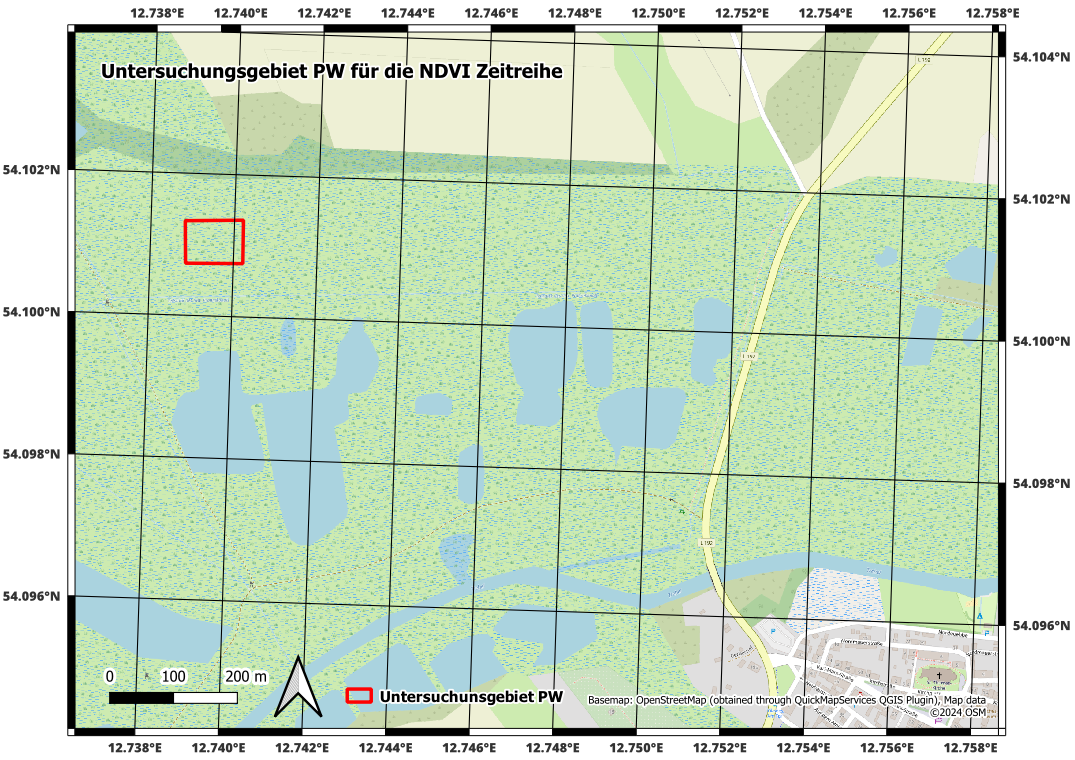

**Filtern des benötigten Datensatzes**

Anschließend kann eine Datei-Kollektion ausgewählt werden, mit welcher gearbeitet werden soll. Informationen über die nutzbaren Bibliotheken können dem folgende Link entnommen werden: https://openeo.cloud/data-collections/

In [4]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A", # Filtern des Datensatzes
    temporal_extent=["2015-07-01", "2024-06-01"], # Filtern des Zeitraumes
    bands=["B04", "B08"], # Filtern der Spektralkanäle
)

**Mit den importierten Spektralkanälen B04 und B08 kann nun der NDVI definiert werden:**

In [5]:
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

**Da eine AOI mehrere Pixel enthalten kann, wird ein Mittelwert für jede AOI (in diesem Fall eine AOI) berechnet**

In [6]:
timeseries = ndvi.aggregate_spatial(geometries=fields, reducer="mean")

**Durchführung eines Sammelprozesses (Batch-Job / Batch-Prozess)**

Um nun die benötigten Daten (für die AOI und den angegebenen Zeitraum) in diesem Falle als CSV herunterzuladen, muss ein sogenannter "Batch-Prozess" durchgeführt werden. Ein Batch-Prozess kann dabei als ein Sammelprozess verstanden werden. Für einfache bzw. kleine Datensätze werden meist synchrone HTTP Anfragen an einen Server gestellt und das Ergebnis wird als direkte Antwort erhalten. Bei größeren bzw. aufwändigeren Prozessen, wie in diesem Fall, müssen hingegen Sammelprozesse gestartet werden. 

In [7]:
job = timeseries.execute_batch(out_format="CSV", title="NDVI timeseries")

0:00:00 Job 'j-240628e2d21040be89ef43563fbed9d0': send 'start'
0:00:31 Job 'j-240628e2d21040be89ef43563fbed9d0': created (progress 0%)
0:00:36 Job 'j-240628e2d21040be89ef43563fbed9d0': created (progress 0%)
0:00:43 Job 'j-240628e2d21040be89ef43563fbed9d0': created (progress 0%)
0:00:51 Job 'j-240628e2d21040be89ef43563fbed9d0': created (progress 0%)
0:01:01 Job 'j-240628e2d21040be89ef43563fbed9d0': created (progress 0%)
0:01:13 Job 'j-240628e2d21040be89ef43563fbed9d0': created (progress 0%)
0:01:29 Job 'j-240628e2d21040be89ef43563fbed9d0': created (progress 0%)
0:01:48 Job 'j-240628e2d21040be89ef43563fbed9d0': created (progress 0%)
0:02:12 Job 'j-240628e2d21040be89ef43563fbed9d0': running (progress N/A)
0:02:42 Job 'j-240628e2d21040be89ef43563fbed9d0': running (progress N/A)
0:03:20 Job 'j-240628e2d21040be89ef43563fbed9d0': running (progress N/A)
0:04:06 Job 'j-240628e2d21040be89ef43563fbed9d0': running (progress N/A)
0:05:06 Job 'j-240628e2d21040be89ef43563fbed9d0': running (progress N

**Nachdem der Batch-Prozess abgeschlossen ist, können die Ergebnisse heruntergeladen werden und die CSV-Datei kann anschließend importiert werden:**

In [8]:
job.get_results().download_file("ndvi-results/timeseries-basic_PW.csv")
pd.read_csv("ndvi-results/timeseries-basic_PW.csv", index_col=0).head()

,feature_index,band_unnamed
date,,
2015-08-19T00:00:00.000Z,0,0.818703
2015-12-24T00:00:00.000Z,0,0.161081
2017-03-21T00:00:00.000Z,0,0.459600
2017-03-20T00:00:00.000Z,0,0.078060
2017-07-16T00:00:00.000Z,0,0.061081


**Hier wird eine Hilfsfunktion erstellt, um einfache Zwischenergebnisse schnell zu plotten:**

In [9]:
def plot_timeseries(filename, figsize=(6, 3)):
    df = pd.read_csv(filename, index_col=0)
    df.index = pd.to_datetime(df.index)

    fig, ax = plt.subplots(figsize=figsize, dpi=90)
    df.groupby("feature_index")["band_unnamed"].plot(marker=",", ax=ax)
    ax.set_title(filename.split("/")[-1])
    ax.set_ylabel("NDVI")
    ax.set_ylim(0, 1)
    ax.legend(title="parcel id", loc="lower left", ncol=2)

**Nun wird die erste NDVI-Zeitreihe mit der Hilfsfunktion geplottet. Dabei sind jedoch Störfaktorern wie zum Beispiel Wolken noch nicht gefiltert.** 

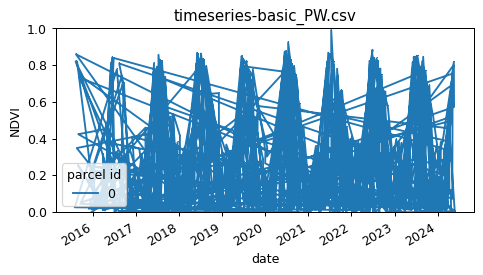

In [10]:
plot_timeseries("ndvi-results/timeseries-basic_PW.csv")

Bei Betrachtung des zuvor erstellten Plots fällt auf, dass dieser sehr durcheinander und willkürlich erscheint. Dies hat u.a. die Gründe, dass bewölkte Beobachtungen zuvor nicht herausgefiltert wurden und die generierte CSV-Datei noch nicht sortiert ist. Daher wird nun erneut die Sentinel-2 Kollektion geladen. Dabei wird zusätzlich das SCL-Band genutzt. Das SCL-Band steht für "Scene Classification" und stellt eine von der ESA bereits klassifizierte Sentinel-2 Szene dar. Dabei wird zwischen 11 Klassen unterschieden. Weitere Infos dazu sind unter nachgolgendem Link zu finden: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/.

In [11]:
s2cube = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2015-07-01", "2024-06-01"],
    bands=["B04", "B08", "SCL"], # Hier ist nun das SCL-Band inkludiert
)

# Der NDVI wird ebenfalls erneut berechnet
red = s2cube.band("B04")
nir = s2cube.band("B08")
ndvi = (nir - red) / (nir + red)

**Nun wird eine Maske für alle Flächen erstellt, die alle Flächen inkludiert die Vegetationsflächen und keine Vegetationsflächen (z.B. Labndwirtschaftliche Flächen) darstellen:**

In [12]:
scl = s2cube.band("SCL")
mask = ~((scl == 4) | (scl == 5)) # 4 - Vegetationsflächen, 5 - keine Vegetationsflächen (z.B. Ackerland)

**Glättung und Erstellen einer SCL-Maske**

Da das SCL-Band bei Sentinel-2 Bändern (auch seitens der ESA) keine perfekte Klassifikation ist und Störungen beinhalten kann, werden diese Szenen als nächstes geglättet. Dazu wird eine zweidimensionale Gauß'sche Filtermaske (Kernel) erstellt, welcher zur Glättung der Szene verwendet wird. Die Standardabweigung gibt dabei an, wie stark das Bild geglättet wird (je höher, desto stärker die Glättung). Damit dieser Kernel auch auf verschiedenste Masken angewendet werden kann, wird dieser normalisiert. Der Schwellenwert gibt dabei an, ab wann ein Pixel bzw. Pixelwert als gültig, also "nicht-Vegetation" markiert wird.

In [13]:
g = scipy.signal.windows.gaussian(11, std=1.6) #Gauß'sche Fensterfunktion mit Länge 11 und Standardabweichung von 1.6
kernel = np.outer(g, g)
kernel = kernel / kernel.sum() # normieren durch die Summe aller Elemente des Kernels

mask = mask.apply_kernel(kernel)
mask = mask > 0.1 # Festlegen des Schwellenwertes

**Die zuvor eine Maske erstellte Maske wird nun auf den NDVI angewendet und die Werte werden wieder gemittelt:** 

In [14]:
ndvi_masked = ndvi.mask(mask)
timeseries_masked = ndvi_masked.aggregate_spatial(geometries=fields, reducer="mean")

**Durchführung des Sammelprozesses für die maskierte NDVI-Zeitreihe:**

In [15]:
job = timeseries_masked.execute_batch(out_format="CSV", title="Masked NDVI timeseries")

0:00:00 Job 'j-2406287dc7444da1bcd1fb7767bf071b': send 'start'
0:00:21 Job 'j-2406287dc7444da1bcd1fb7767bf071b': created (progress 0%)
0:00:27 Job 'j-2406287dc7444da1bcd1fb7767bf071b': created (progress 0%)
0:00:33 Job 'j-2406287dc7444da1bcd1fb7767bf071b': created (progress 0%)
0:00:42 Job 'j-2406287dc7444da1bcd1fb7767bf071b': created (progress 0%)
0:00:52 Job 'j-2406287dc7444da1bcd1fb7767bf071b': created (progress 0%)
0:01:04 Job 'j-2406287dc7444da1bcd1fb7767bf071b': running (progress N/A)
0:01:20 Job 'j-2406287dc7444da1bcd1fb7767bf071b': running (progress N/A)
0:01:39 Job 'j-2406287dc7444da1bcd1fb7767bf071b': running (progress N/A)
0:02:03 Job 'j-2406287dc7444da1bcd1fb7767bf071b': running (progress N/A)
0:02:33 Job 'j-2406287dc7444da1bcd1fb7767bf071b': running (progress N/A)
0:03:11 Job 'j-2406287dc7444da1bcd1fb7767bf071b': running (progress N/A)
0:04:03 Job 'j-2406287dc7444da1bcd1fb7767bf071b': running (progress N/A)
0:05:07 Job 'j-2406287dc7444da1bcd1fb7767bf071b': running (progres

**Erneutes Herunterladen der CSV-Datei:**

In [16]:
job.get_results().download_file("ndvi-results/timeseries-masked_PW.csv")

WindowsPath('ndvi-results/timeseries-masked_PW.csv')

**Erstellen eines Zwischenplots für die maskierte Zeitreihe:**

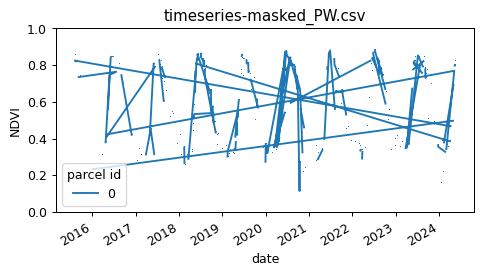

In [17]:
plot_timeseries("ndvi-results/timeseries-masked_PW.csv")

**Zeitreihen-Glättung**

Aufgrund der ausmaskierung von wolkenbedeckten Pixeln, können für die Zeitreihe nun Werte fehlen. Um diese fehlenden Werte im Datenwürfel zu ergänzen und die Zeitreihe zu glätten, werden die fehlenden Werte nun interpoliert und es wird eine zeitliche Glättung der Zeitreihe mit dem Savitzky-Golay-Filter durchgeführt. Der Filter dient außerdem zur reduzierung von Rauschen. Um solche komplexen, nicht standatisierten Prozesse durchzuführen, können sogenannte Usesr-Defined Functions (UDF) genutzt werden. Das ermöglicht die Anwendung solcher Prozesse im Backend.

In [18]:
udf = openeo.UDF(
    """
from scipy.signal import savgol_filter
from openeo.udf import XarrayDataCube

def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    array = cube.get_array()
    filled = array.interpolate_na(dim='t')
    smoothed_array = savgol_filter(filled.values, 5, 2, axis=0)
    return DataCube(xarray.DataArray(smoothed_array, dims=array. dims,coords=array.coords))
"""

)

**Nun wird die UDF entlang der zeitlichen Dimension auf die NDVI-Maske angwendet.**

In [19]:
ndvi_smoothed = ndvi_masked.apply_dimension(code=udf, dimension="t")

**Es erfolgt wieder eine räumliche Mittelung, diesmal für die geglättete Zeitrieihe:**

In [20]:
timeseries_smoothed = ndvi_smoothed.aggregate_spatial(geometries=fields, reducer="mean")

In [21]:
job = timeseries_smoothed.execute_batch(
    out_format="CSV", title="Smoothed NDVI timeseries"
)

0:00:00 Job 'j-2406285e315e4e909d1c2247bd1e085d': send 'start'
0:00:41 Job 'j-2406285e315e4e909d1c2247bd1e085d': created (progress 0%)
0:00:46 Job 'j-2406285e315e4e909d1c2247bd1e085d': created (progress 0%)
0:00:53 Job 'j-2406285e315e4e909d1c2247bd1e085d': created (progress 0%)
0:01:03 Job 'j-2406285e315e4e909d1c2247bd1e085d': created (progress 0%)
0:01:13 Job 'j-2406285e315e4e909d1c2247bd1e085d': created (progress 0%)
0:01:25 Job 'j-2406285e315e4e909d1c2247bd1e085d': created (progress 0%)
0:01:41 Job 'j-2406285e315e4e909d1c2247bd1e085d': created (progress 0%)
0:02:00 Job 'j-2406285e315e4e909d1c2247bd1e085d': created (progress 0%)
0:02:24 Job 'j-2406285e315e4e909d1c2247bd1e085d': running (progress N/A)
0:02:54 Job 'j-2406285e315e4e909d1c2247bd1e085d': running (progress N/A)
0:03:32 Job 'j-2406285e315e4e909d1c2247bd1e085d': running (progress N/A)
0:04:19 Job 'j-2406285e315e4e909d1c2247bd1e085d': running (progress N/A)
0:05:17 Job 'j-2406285e315e4e909d1c2247bd1e085d': running (progress N

In [22]:
job.get_results().download_file("ndvi-results/NDVI_extended_ts_openEO_PW.csv")

WindowsPath('ndvi-results/NDVI_extended_ts_openEO_PW.csv')

**Da die Daten in der CSV-Datei teilweise noch nicht richtig nach der Datumsspalte sortiert sind, wird dies als nächstes umgesetzt, um anschließend die Datenreihe zu plotten.**

In [25]:
# CSV-Datei lesen
with open("ndvi-results/NDVI_extended_ts_openEO_PW.csv", newline='') as csvfile:
    reader = list(csv.reader(csvfile, delimiter=","))
    
    # Kopfzeile beibehalten
    header = reader[0]
    
    # Rest der Daten sortieren nach den Werten/Daten in der 1. Spalte
    sorted_data = sorted(reader[1:])
    
    # Neues DataFrame erstellen
    df = pd.DataFrame(sorted_data, columns=header)
    
    # In eine CSV-Datei speichern
    df.to_csv('final-ndvi-results/NDVI_extended_ts_sorted_openEO_PW.csv', index=False)

print("CSV-Datei wurde erfolgreich sortiert und gespeichert.")

CSV-Datei wurde erfolgreich sortiert und gespeichert.


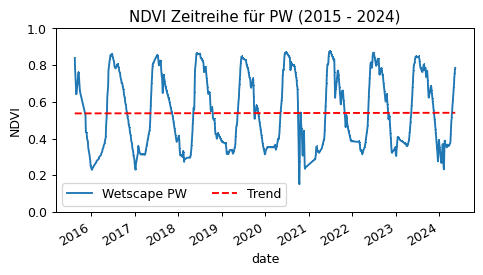

In [27]:

df = pd.read_csv("final-ndvi-results/NDVI_extended_ts_sorted_openEO_PW.csv", index_col="date")
df.index = pd.to_datetime(df.index) # in Datumsformat konvertieren

#Mittelwerte der Gruppen als Daten für die Trendlinie
mean_values = df.groupby(df.index)["band_unnamed"].mean()

#NaN Werte aus den Daten entfernen, da sonst eine Fehlermeldung beim erstellen der Trendlinie auftritt
mean_values = mean_values.dropna()

x = np.arange(len(mean_values))
y = mean_values.values

z = np.polyfit(x, y, 1)  #Lineare Regression / Die Zahl am Ende gibt die Ordnung des Polynoms für die Regression an
p = np.poly1d(z)

#Erstellen des Plots
fig, ax = plt.subplots(figsize=(6,3), dpi=90)
df.groupby("feature_index")["band_unnamed"].plot(marker=",", ax=ax)
ax.plot(mean_values.index, p(x), "r--", label="Trendlinie")
ax.set_title("NDVI Zeitreihe für PW (2015 - 2024)")
ax.set_ylabel("NDVI")
ax.set_ylim(0, 1)
ax.legend(["Wetscape PW", "Trend"], loc="lower left", ncol=2)

fig.savefig("Plots/Plot_PW_NDVI_extended_ts.svg", format="svg")